<a href="https://colab.research.google.com/github/Nick-FF/NeuroNets_Begining/blob/Less5/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%A3%D1%80%D0%BE%D0%BA5_05_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Практическое занятие к уроку 5

In [ ]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
import os
import datetime

In [ ]:
%load_ext tensorboard

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [ ]:
# files.upload()
# !ls
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/airline-passengers.csv')
df.index = df.Month
df.drop(['Month'],axis=1,inplace = True)
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


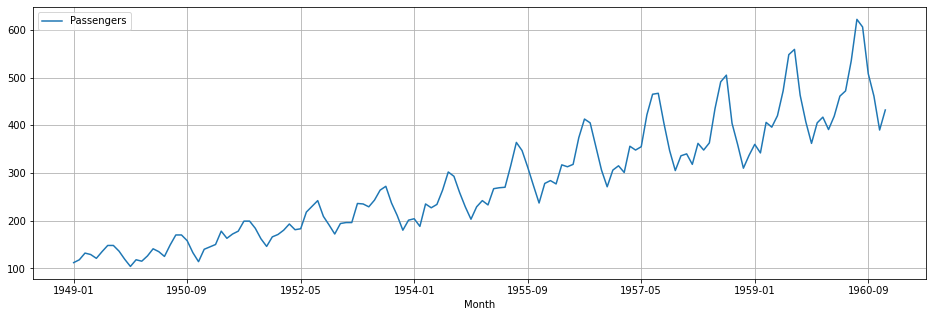

In [ ]:
df.plot( figsize = (16,5))
plt.grid('On')
plt.show()

Подготовим данные

In [ ]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [ ]:
data = df.copy()
data.shape

(144, 1)

In [ ]:
train_split = 100
data_v =  normalize(data.values, train_split)
data_f = pd.DataFrame(data_v)

In [ ]:
# список признаков, по которым будем учить
channelIndexes = [0]

# длина теста
# valLen = 100
# длина истории для работы
xLen = 12
# отступ тестов от тренировок
bias = 2

# вычисляем точку разделения ряда на тесты и тренировку
#train_split = data_f.shape[0] - valLen - bias
# делим
train_data = data_f.iloc[0 : train_split ,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]


In [ ]:
val_data.head()

,0
102,3.339814
103,3.366896
104,2.513798
105,1.741946
106,1.173214


In [ ]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 10

In [ ]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [ ]:
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(88, 1)
(88,)
(30, 1)
(30,)


<function matplotlib.pyplot.show>

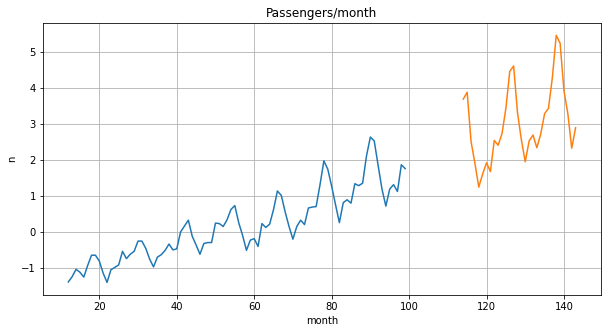

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid('on')
plt.xlabel('month')
plt.ylabel('n')
#plt.title('стоимость BRENT в 2010-2018')
plt.title('Passengers/month')
plt.show

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (19, 12, 1)
Target shape: (19,)


In [ ]:
inputs[1,:,0]

<tf.Tensor: shape=(12,), dtype=float64, numpy=
array([3.36689629, 2.51379757, 1.74194634, 1.17321386, 1.5929926 ,
       1.6471576 , 1.34925011, 1.94506509, 1.75548759, 1.95860634,
       2.9335763 , 3.69188628])>

In [ ]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=3.6918862775532126>

Данные для тренировки и валидации подготовлены

---

In [ ]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

Построим модель

Epoch 1/100
3/3 [==============================] - 18s 1s/step - loss: 0.6061 - mae: 0.6510 - val_loss: 7.6862 - val_mae: 2.6137
Epoch 2/100
3/3 [==============================] - 0s 107ms/step - loss: 0.5456 - mae: 0.6157 - val_loss: 6.8546 - val_mae: 2.4518
Epoch 3/100
3/3 [==============================] - 0s 109ms/step - loss: 0.4671 - mae: 0.5659 - val_loss: 5.5855 - val_mae: 2.1828
Epoch 4/100
3/3 [==============================] - 0s 118ms/step - loss: 0.3504 - mae: 0.4809 - val_loss: 3.7862 - val_mae: 1.7334
Epoch 5/100
3/3 [==============================] - 0s 105ms/step - loss: 0.2091 - mae: 0.3526 - val_loss: 1.7541 - val_mae: 1.0428
Epoch 6/100
3/3 [==============================] - 0s 103ms/step - loss: 0.1522 - mae: 0.2961 - val_loss: 0.7057 - val_mae: 0.6258
Epoch 7/100
3/3 [==============================] - 0s 109ms/step - loss: 0.2412 - mae: 0.4265 - val_loss: 0.6724 - val_mae: 0.6233
Epoch 8/100
3/3 [==============================] - 0s 108ms/step - loss: 0.1830 - mae

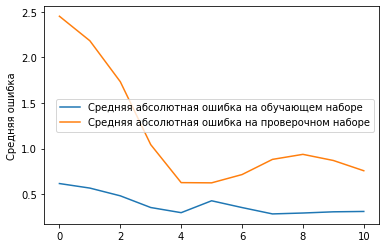

In [ ]:
epochs = 100
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True"))
model.add(Conv1D(64, 3, activation="linear"))
model.add(Flatten())                       
model.add(Dense(3, activation="linear")) 

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

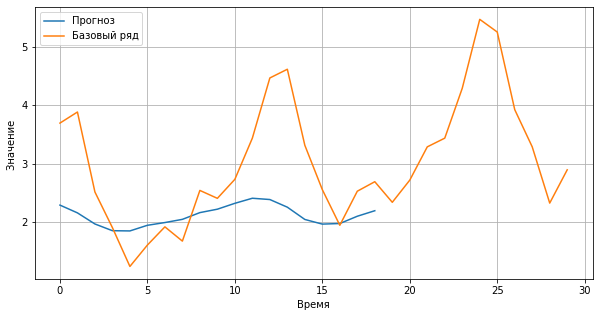

In [ ]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal, 
         label='Прогноз')
plt.plot(yVal.flatten(), 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()